In [1]:
import tensorflow as tf
import pickle as pickle
import numpy as np
import pandas as pd
import glob
from codecarbon import EmissionsTracker
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
tracker = EmissionsTracker()
tracker.start()


# to include the Repo code without installing in the environment
import sys
sys.path.append('../')

from CBKGE.NN_creation_and_dependencies import *
from CBKGE.NN_preproc import *
from CBKGE.utilities_validation import *
tracker.stop()


2025-01-22 12:30:19.314697: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-22 12:30:19.368843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 12:30:19.368859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 12:30:19.369852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 12:30:19.379026: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-22 12:30:19.379437: I tensorflow/core/platform/cpu_feature_guard.cc:1

9.188387013462168e-06

## Import, preprocessing and training configurations

In [2]:
###############
#### TRAINING 
###############


#NYT10M_New     euclidean	swish	0.0005	0.01	15	0.01	5	256	kNN_chunks	15	similarity  
#NYT10D_New     euclidean	swish	0.0005	0.01	15	0.01	5	256	kNN_chunks	15	similarity	
#Wiki20m_new    euclidean	swish	0.0005	0.01	15	0.01	5	256	kNN_chunks	15	similarity	
#Wiki20D_new    euclidean	swish	0.0005	0.01	15	0.01	5	256	kNN_chunks	15	similarity	
#DisRex_new     euclidean	swish	0.0005	0.01	15	0.01	5	256	kNN_chunks	15	similarity	

configuration = {'input_shape': 1536,#2304, # 1536,
                 'architecture':'MLP',
                 'distance':'euclidean',#'cosine',#'euclidean',
                 'activation':'swish', #'swish',#tf.math.sin,
                 'learning_rate':0.0005,
                 'temperature':0.01,
                 'base_temperature':1,
                 'optimizer':tf.keras.optimizers.serialize(tf.keras.optimizers.AdamW(), use_legacy_format=True),#tf.keras.optimizers.legacy.Adam(),
                 'output_dimensions':15,
                 'depth':5,#5
                 'pert': 0.01,
                 'epochs':50,
                 'batch_size':256,
                 'similarity_to_class':'kNN_chunks',#'w_average'#'kNN_chunks',  #'centroid','w_average','kNN_chunks'
                 'val_batch':100000,
                 'kNN':50,
                 'n_jobs':-1,
                 'top_perf':1000,

                 'classic_kNN':True,
                 
                 'eval_method':'multi', #NEW 'multi', 'unroll', 'isin', model/performance evaluation method
                 'threshold':0.5,  #NEW threshold to be used in 'multi' to go from relation probabilities to relation occurrences
                 
                 'loss':'similarity', ##NEW 'jaccard' 'similarity'      
                 'jaccard_threshold':0.3, ##NEW threshold for 'jaccard' loss
                 
                 'balance_triples':False,
                 'quantile_cutoff_balancing':0.95,
                 'balance_labels':False, ## NEW! No balance, triple balance, triple+labels balance
                 
                 'bag_threshold':0.,   ##NEW (when using 'multi') percentage cutoff for bag label appearence
                 'get_thresholds':False,
                 'return_headtail':False,
                 'other_top_perf':[100,200,300],
                 'calibrated':False,
                 'harmonic_score':True,
                 'cls':False
                }


if configuration['eval_method']=='multi':
    configuration['return_headtail']=False

In [3]:
## want to extract dataset name from sh command line

dataset="wiki20distant"


dict_dataset={}
dict_dataset = {
    'nyt10d': {'train': 'Final/NYT10D/Train/', 
               'test': 'Final/NYT10D/Test/', 
               'val': None},
    'nyt10m': {'train': 'Final/NYT10m/Train/',
               'test': 'Final/NYT10m/Test/',
               'val': 'Final/NYT10m/Val/'},
    'wiki20m': {'train': 'Final/Wiki20m/Train/',
                'test': 'Final/Wiki20m/Test/',
                'val': 'Final/Wiki20m/Val/'},
    'disrex': {'train': 'Final/DisRex/Train/',
               'test': 'Final/DisRex/Test/',
               'val': 'Final/DisRex/Val/'},
    'wiki20distant': {'train': 'Final/Wiki20mDistant/Train/',
                      'test': 'Final/Wiki20m/Test/',
                      'val': 'Final/Wiki20mDistant/Val/'}
}


path_train=dict_dataset[dataset]['train']
path_test=dict_dataset[dataset]['test']
if dict_dataset[dataset]['val'] is not None:
    path_val=dict_dataset[dataset]['val']
    validation=True
else:
    validation=False




file_list_train=glob.glob(path_train+"*.pkl")
file_list_test=glob.glob(path_test+"*.pkl")
if validation:
    file_list_val=glob.glob(path_val+"*.pkl")



configuration['class_probabilities'],link_dict, training_dataset, train_df = from_file_list_to_tfdataset(file_list_train, 
                                                          balance_triples=configuration['balance_triples'], 
                                                          quantile_cutoff=configuration['quantile_cutoff_balancing'],
                                                          balance_labels=configuration['balance_labels'],
                                                          cls=configuration['cls'],
                                                          return_df=True,
                                                          get_thresholds=True)
_, test_dataset = from_file_list_to_tfdataset(file_list_test, 
                                            relation_dict=link_dict,
                                            return_df=False,
                                            return_headtail=configuration['return_headtail'],
                                            cls=configuration['cls'])
if validation:
    _, validation_dataset = from_file_list_to_tfdataset(file_list_val, 
                                                        relation_dict=link_dict, 
                                                        balance_triples=False,  
                                                        quantile_cutoff=configuration['quantile_cutoff_balancing'],
                                                        balance_labels=False,
                                                        cls=configuration['cls'])
    

buffer_size=len(training_dataset)
configuration['val_batch'] = len(training_dataset)
training_dataset=training_dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
test_dataset=test_dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
if validation:
    validation_dataset=validation_dataset.shuffle(buffer_size, reshuffle_each_iteration=True)

Dataset loaded
Relations mapped
original balancing [ 3898   871  1528   687  3961  1147  5358  2805   239  2887  2570  4533
  5562  5367   364  1432  4087  4345  7585  2970  9545   932  7797  2703
  5299   794  5169  4494  1625  8662  1519  1662  3317  6843  6626  5936
   225  1963  1541  2178   293  6062  6606   649  4478  5615  2072  7154
  8065  2810  3700  5828  1100   486  3816   850  4254  7762  2994  1095
  1562  2406  4649  4064  4794  5169 11284  6590  5344  7947  6100   861
  2876  4134  1894  4857  1720  4084  3562 12013  6937   899  8704 10204
   934  1238  6730   860  1123  1185  2935  6695  6451  3504  2486   338
  7387    67  2298  2723  5868  2016  4755  4866  9906  1907   390  5576
  1195  4662  6986  4185   376   670  4596   577  2985  4998   346  1845
   911  1176  3704  5388  2233  1090   788  3259  2902  2648    11  3464
  5172   430  3752   185   269  2651  4873  6540   960  1162  7110  3797
  1521   281  2521  1525   891  2718  3142  1479   303  2806    92   168


2025-01-22 12:40:26.899296: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3773687808 exceeds 10% of free system memory.


tfdataset created
Dataset loaded
Relations mapped
original balancing [   0    0    0    0    0    0    0    0    0    0    0  700    0    0
    0    0    0  728  702    0  699    0    0 1121  991    0 1068  993
 1126 1801    0 1259 1890    0 1332 1174    0    0 2069    0    0 1940
  735    0    0    0    0    0    0  700  700  700    0    0    0    0
    0    0    0    0  924 2340    0 1186    0    0    0    0  879    0
  700    0    0 1502    0 1119    0    0    0  757  857    0 1119  796
  700    0    0    0    0    0    0    0 1590 1490    0    0  910    0
 1079    0  700  700    0    0    0    0    0 1693    0  700  700  860
    0    0  837    0  719 1930    0    0    0 4409    0    0 2066    0
    0  700    0  699    0    0    0    0 1864    0    0    0 2529 1776
    0    0  848    0    0    0    0    0    0    0    0    0    0  711
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 1270    0    0    0    0    0 1378    0  767    0 2276  821 1556    0
    0   

In [4]:
tf.keras.backend.clear_session()
model = CreateModel(training_configuration = configuration)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 500)               768500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dense_5 (Dense)             (None, 15)                7

In [5]:
#Set true if you have a pre-trained model (first time set to False)
weights=False

## Model training 

In [6]:

if weights:
    model.load_weights("/home/lucamariotti/Documents/CBKGE/Notebooks/wiki20distant_model_0.h5")
    print("Weights loaded from: ", weights)
    print("Model loaded from: ", weights)
else:
    print("Model created from scratch")
    if validation:
        callback= tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)


        history = model.fit(training_dataset.batch(configuration['batch_size']),
                                                    epochs = configuration['epochs'], 
                                                    validation_data=validation_dataset.batch(configuration['batch_size']), 
                                                    callbacks=[callback])

    else:
        callback= tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=1e-4,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)


        history = model.fit(training_dataset.batch(configuration['batch_size']),
                            epochs = configuration['epochs'], 
                            callbacks=[callback])    


Model created from scratch
Epoch 1/50
501/501 [==============================] - 11s 21ms/step - loss: 0.0435 - val_loss: 0.0409
Epoch 2/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0380 - val_loss: 0.0402
Epoch 3/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0368 - val_loss: 0.0395
Epoch 4/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0359 - val_loss: 0.0391
Epoch 5/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0352 - val_loss: 0.0393
Epoch 6/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0347 - val_loss: 0.0392
Epoch 7/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0342 - val_loss: 0.0393
Epoch 8/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0338 - val_loss: 0.0394
Epoch 9/50
501/501 [==============================] - 10s 20ms/step - loss: 0.0334 - val_loss: 0.0392
Epoch 10/50
501/501 [==============================] - 

## Print results

In [7]:
if not validation:
    validation_dataset=training_dataset
list_results=[]
row_keys=[]
for bool_bayesian in [False]:
    for calibrated in [False]:
        for harmonic_score in [True]:
            row_results=[]
            configuration['get_thresholds']=bool_bayesian
            configuration['calibrated']=calibrated
            configuration['harmonic_score']=harmonic_score

            test_y_true, test_y_pred, test_y_score, results_perf, best_indices, test_y_pred_at_R = evaluation_and_performance(test_configuration=configuration,
                                                                                training_dataset=training_dataset,
                                                                                test_dataset=test_dataset,
                                                                                model=model
                                                                                )
            
            if bool_bayesian==True and calibrated==True and harmonic_score==True:
                print('\n\n RESULT USING CALIBRATED BAYESIAN FORMULATION HARMONIC')
                row_keys.append('BCH')
            elif bool_bayesian==True and calibrated==True and harmonic_score==False:
                print('\n\n RESULT USING CALIBRATED BAYESIAN FORMULATION MEAN')
                row_keys.append('BCM')
            elif bool_bayesian==True and calibrated==False and harmonic_score==True:
                print('\n\n RESULT USING BAYESIAN FORMULATION HARMONIC')
                row_keys.append('BH')
            elif bool_bayesian==True and calibrated==False and harmonic_score==False:
                print('\n\n RESULT USING BAYESIAN FORMULATION MEAN')
                row_keys.append('BM')
            elif bool_bayesian==False and calibrated==True and harmonic_score==True:
                print('\n\n RESULT USING CALIBRATED LIKELIHOOD FORMULATION HARMONIC')
                row_keys.append('LCH')
            elif bool_bayesian==False and calibrated==True and harmonic_score==False:
                print('\n\n RESULT USING CALIBRATED LIKELIHOOD FORMULATION MEAN')
                row_keys.append('LCM')
            elif bool_bayesian==False and calibrated==False and harmonic_score==True:
                print('\n\n RESULT USING LIKELIHOOD FORMULATION HARMONIC')
                row_keys.append('LH')
            else: 
                print('\n\n RESULT USING LIKELIHOOD FORMULATION MEAN')
                row_keys.append('LM')
            print('Performance on the whole validation set:\n')
            for key in results_perf['total']:
                if key!='list_f1':
                    perf=results_perf['total'][key]
                    print(f'{key}: {perf}')
                    row_results.append(perf)

            for atX in configuration['other_top_perf']:
                top_string='@'+str(atX)
                print(f'\n\Performance {top_string} on validation set:\n')
                for key in results_perf[f'@'+str(atX)]:
                    if key!='list_f1':
                        perf=results_perf[f'@'+str(atX)][key]
                        print(f'{key}: {perf}')
                        row_results.append(perf)

            top_string='@'+str(configuration['top_perf'])
            print(f'\n\Performance {top_string} on validation set:\n')
            for key in results_perf[f'@'+str(configuration['top_perf'])]:
                if key!='list_f1':
                    perf=results_perf[f'@'+str(configuration['top_perf'])][key]
                    print(f'{key}: {perf}')
                    row_results.append(perf)

            PatR=precision_at_R_ml(test_y_true, test_y_pred_at_R)
            print(f'Precision @R: {PatR}')
            
            row_results.append(PatR)

            list_results.append(row_results)


model kNN ml prediction 1778015
model weights skeleton 1778015
model process_train_batch_kNN skeleton 1778015
model process_train_batch_kNN model_weights 1778015
(33399, 36) (33399, 36)
multi 


 RESULT USING LIKELIHOOD FORMULATION HARMONIC
Performance on the whole validation set:

microf1: 0.7524192033070274
macrof1: 0.6156655900549372

\Performance @100 on validation set:

microf1: 0.8508771929824561
macrof1: 0.648511561034247

\Performance @200 on validation set:

microf1: 0.827433628318584
macrof1: 0.6612216066761522

\Performance @300 on validation set:

microf1: 0.8338278931750742
macrof1: 0.6987218763099474

\Performance @1000 on validation set:

microf1: 0.85121412803532
macrof1: 0.596658617380782
Precision @R: 0.7647808816631236


## Correlation Structure Distance Calculation

In [11]:

def significant_correlation_matrix(one_hot_labels, link_dict, alpha=0.05):
    """
    Plots a heatmap of significant correlations between classes.

    Parameters:
    - one_hot_labels: array-like, shape (n_samples, n_classes)
      One-hot encoded labels.
    - link_dict: dict
      Dictionary with class names as keys.
    - alpha: float, optional (default=0.05)
      Significance level for correlations.
    """
    # Convert the one-hot array to a DataFrame for easier manipulation
    df = pd.DataFrame(one_hot_labels, columns=link_dict.keys())

    # Calculate the correlation matrix and the p-value matrix
    correlation_matrix = df.corr()
    p_value_matrix = pd.DataFrame(np.zeros(correlation_matrix.shape), columns=correlation_matrix.columns, index=correlation_matrix.index)

    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            if i != j:
                _, p_value_matrix.iat[i, j] = pearsonr(df.iloc[:, i], df.iloc[:, j])

    # Create a mask for significant correlations
    significant_mask = p_value_matrix < alpha
    # Set diagonal of correlation_matrix_test to value 0
    np.fill_diagonal(correlation_matrix.values, 0.)
    return correlation_matrix, significant_mask



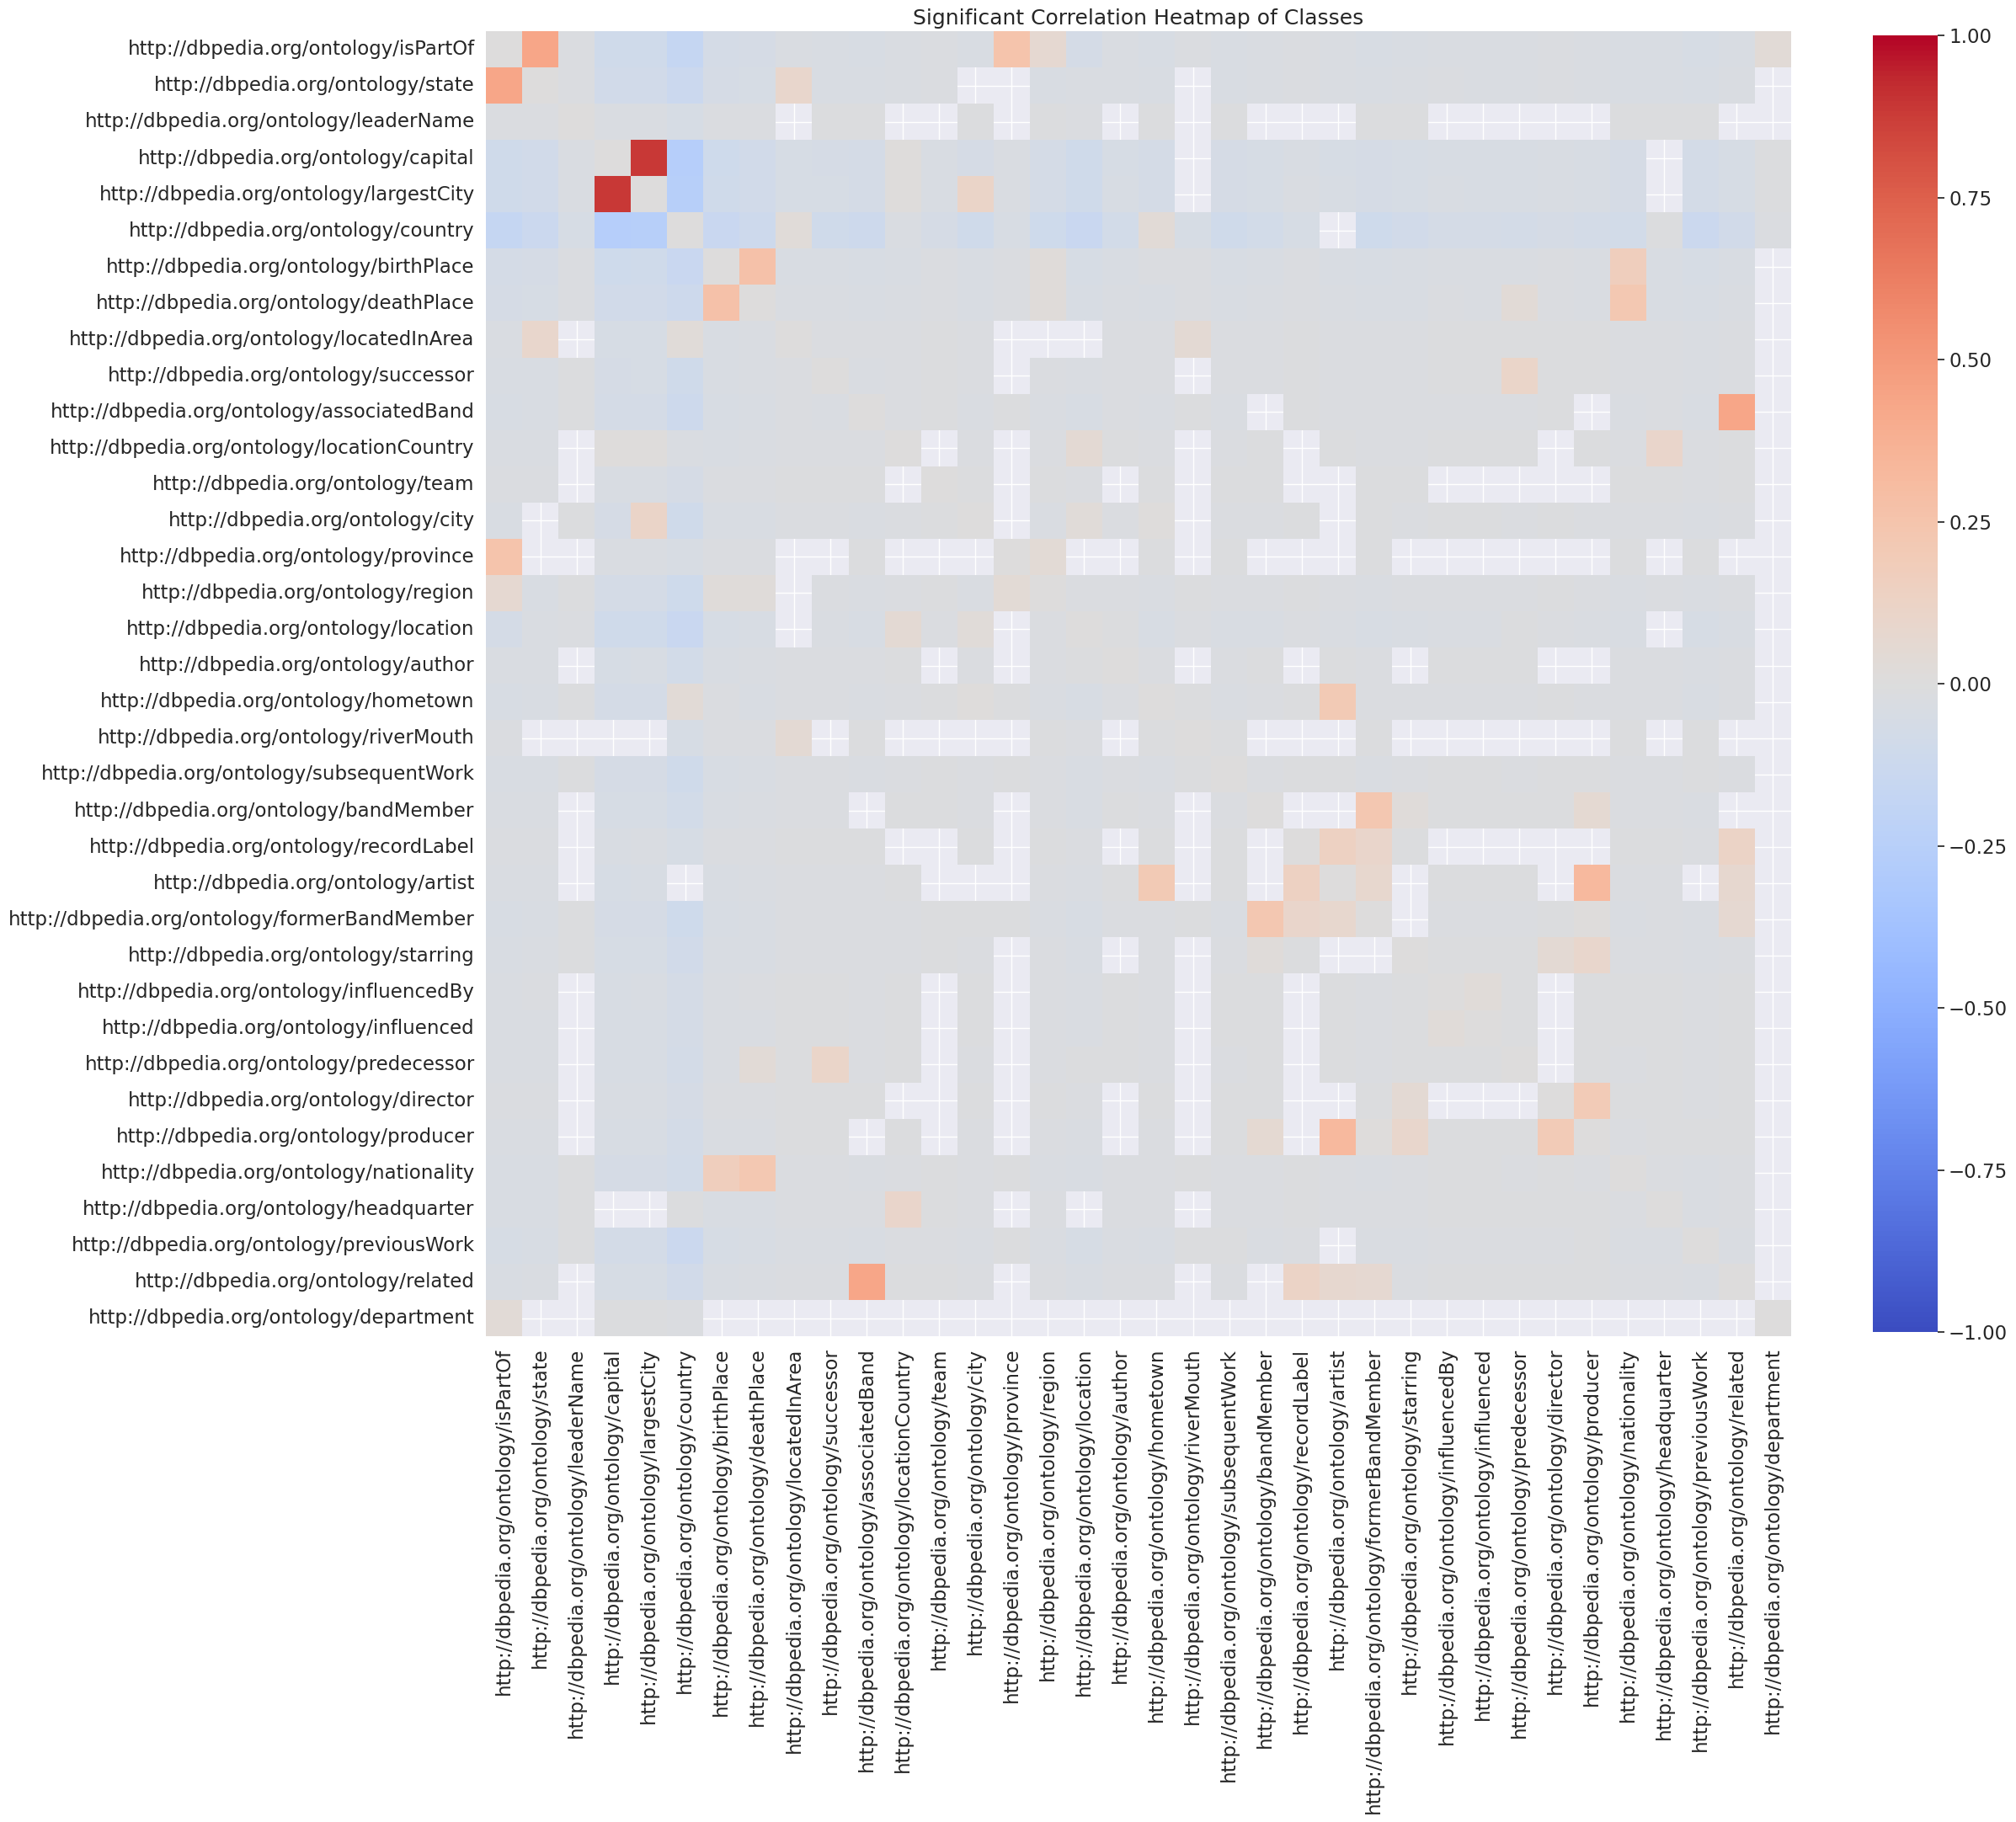

In [61]:
test_correlation_matrix, significant_mask = significant_correlation_matrix(test_y_true, link_dict, alpha=0.05)


# Plot the heatmap with significant correlations highlighted
plt.figure(figsize=(25, 25))
sns.heatmap(test_correlation_matrix, annot=False, cmap='coolwarm', mask=~significant_mask, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Significant Correlation Heatmap of Classes")
plt.grid(True)
plt.show()


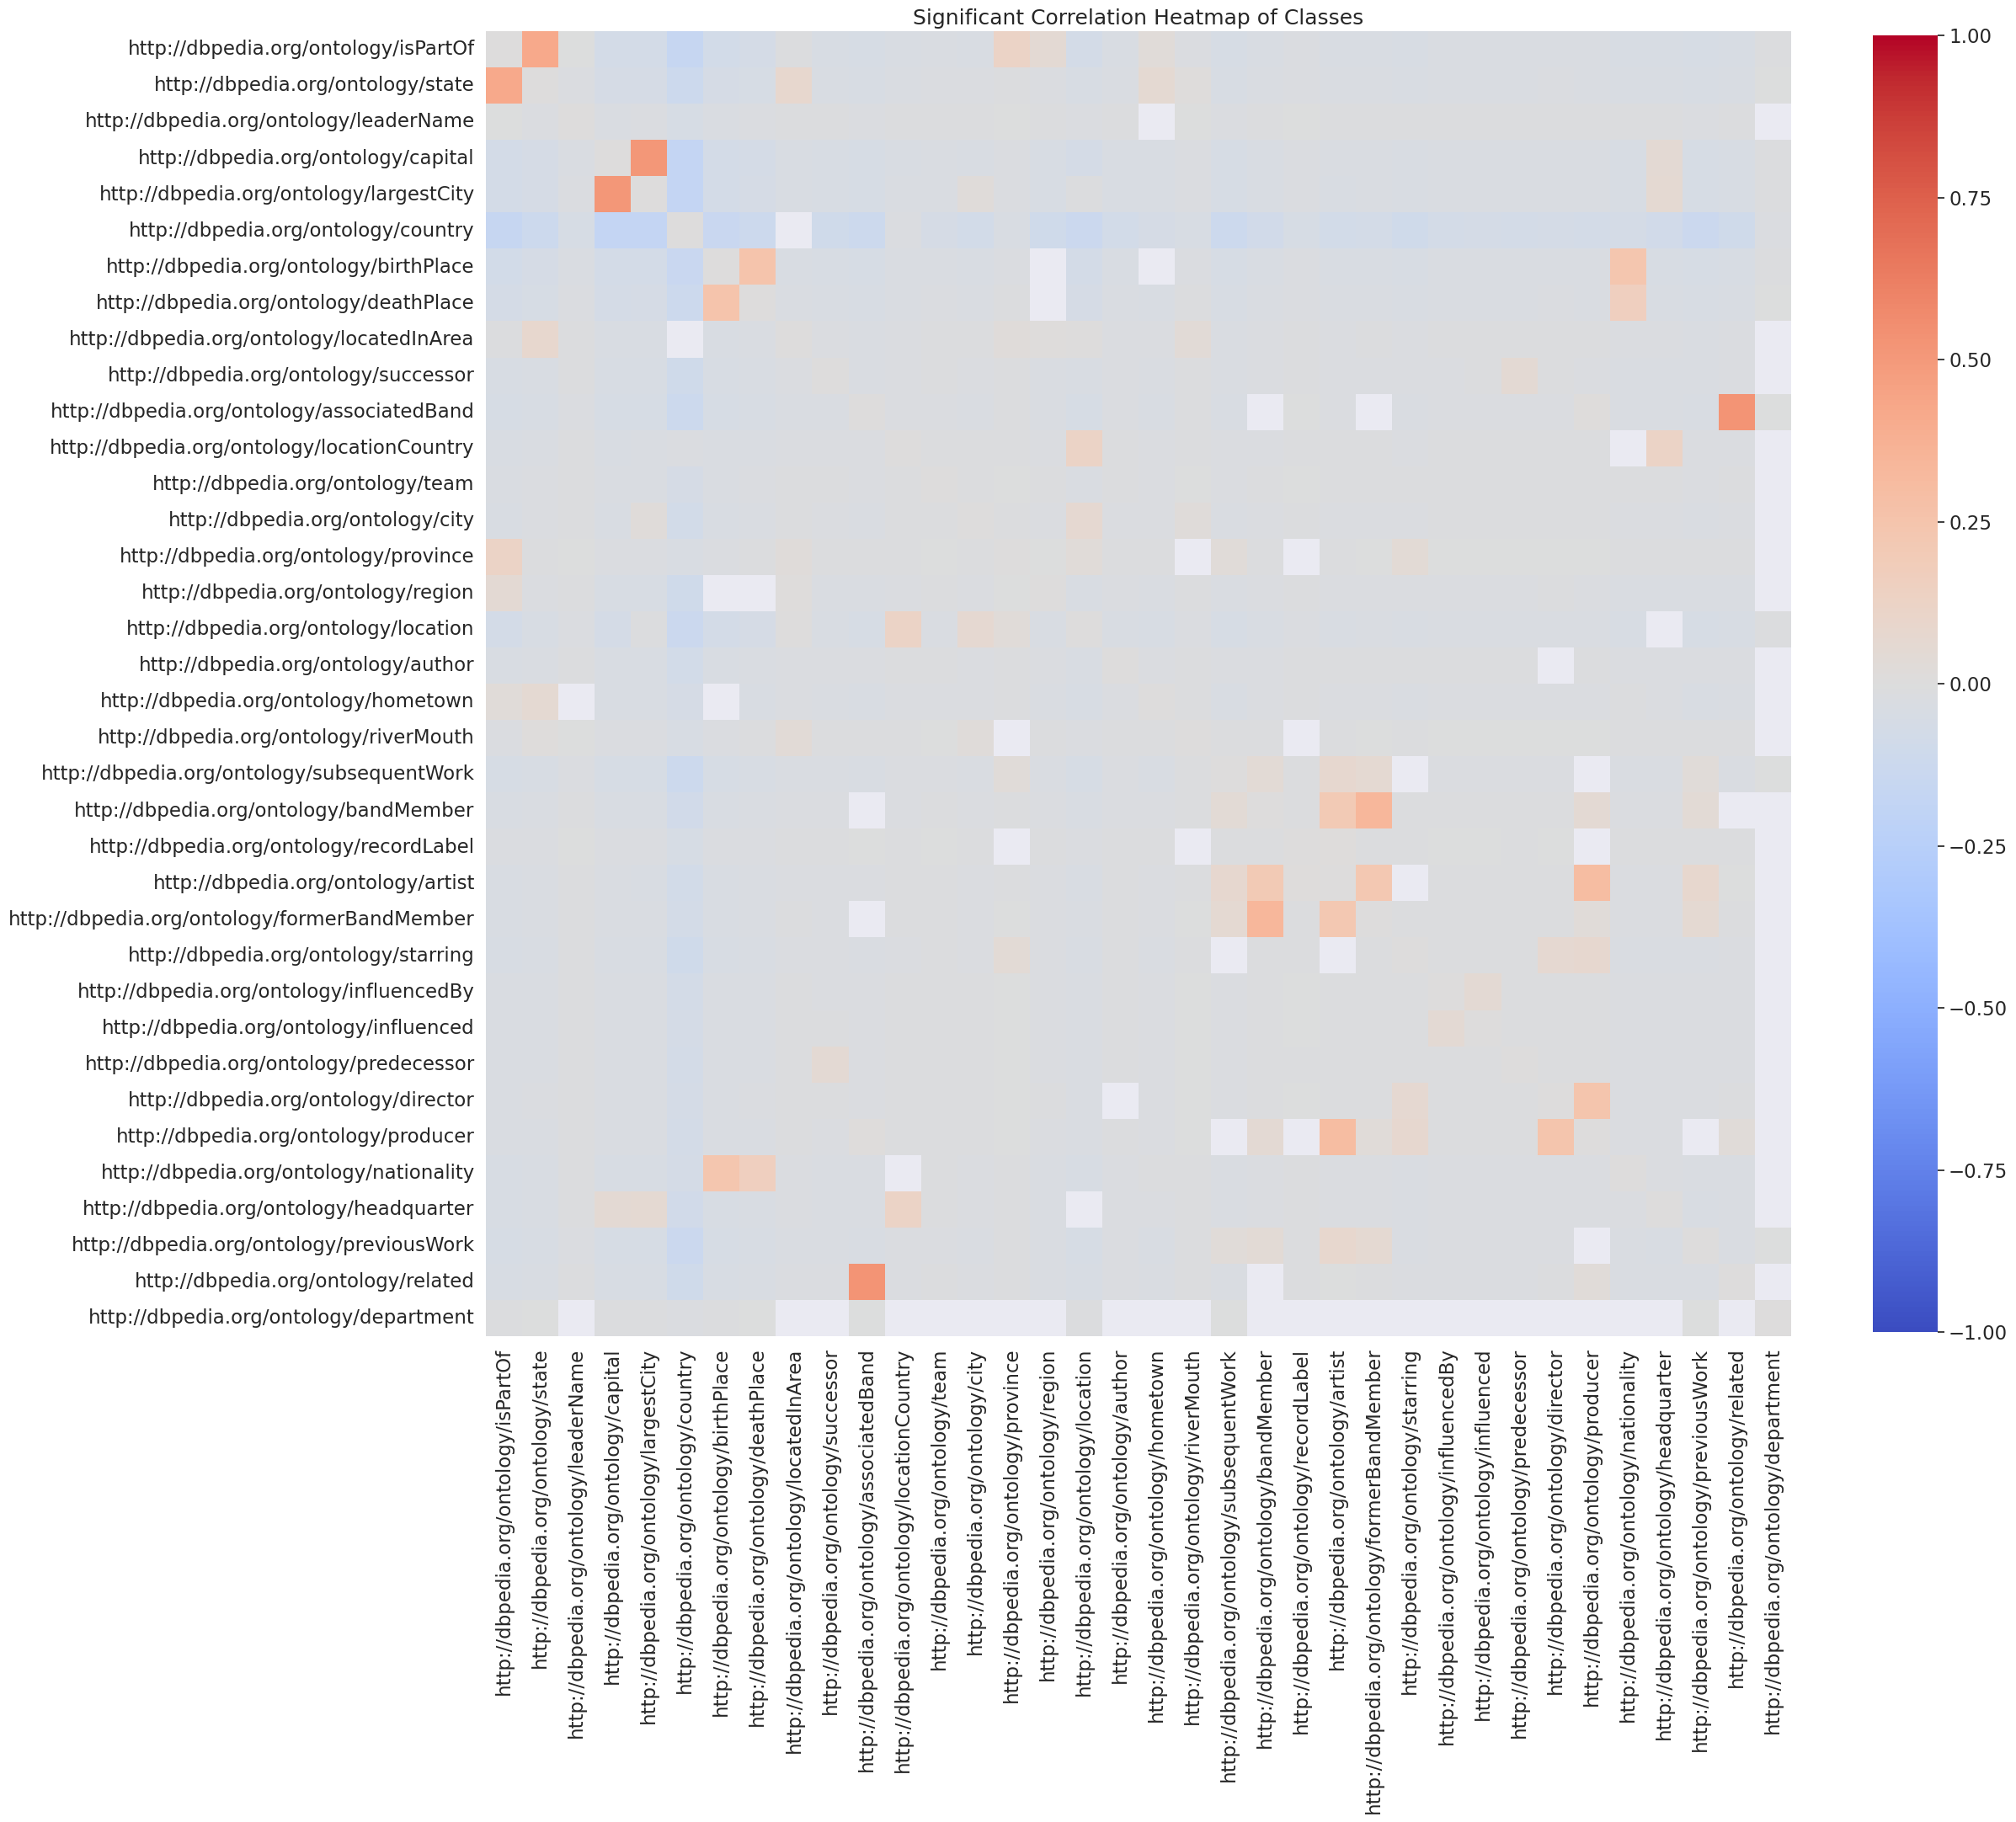

In [13]:
train_correlation_matrix, significant_mask = significant_correlation_matrix(np.array(train_df['link_name'].tolist()), link_dict, alpha=0.05)


# Plot the heatmap with significant correlations highlighted
plt.figure(figsize=(25, 25))
sns.heatmap(train_correlation_matrix, annot=False, cmap='coolwarm', mask=~significant_mask, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Significant Correlation Heatmap of Classes")
plt.grid(False)
plt.show()


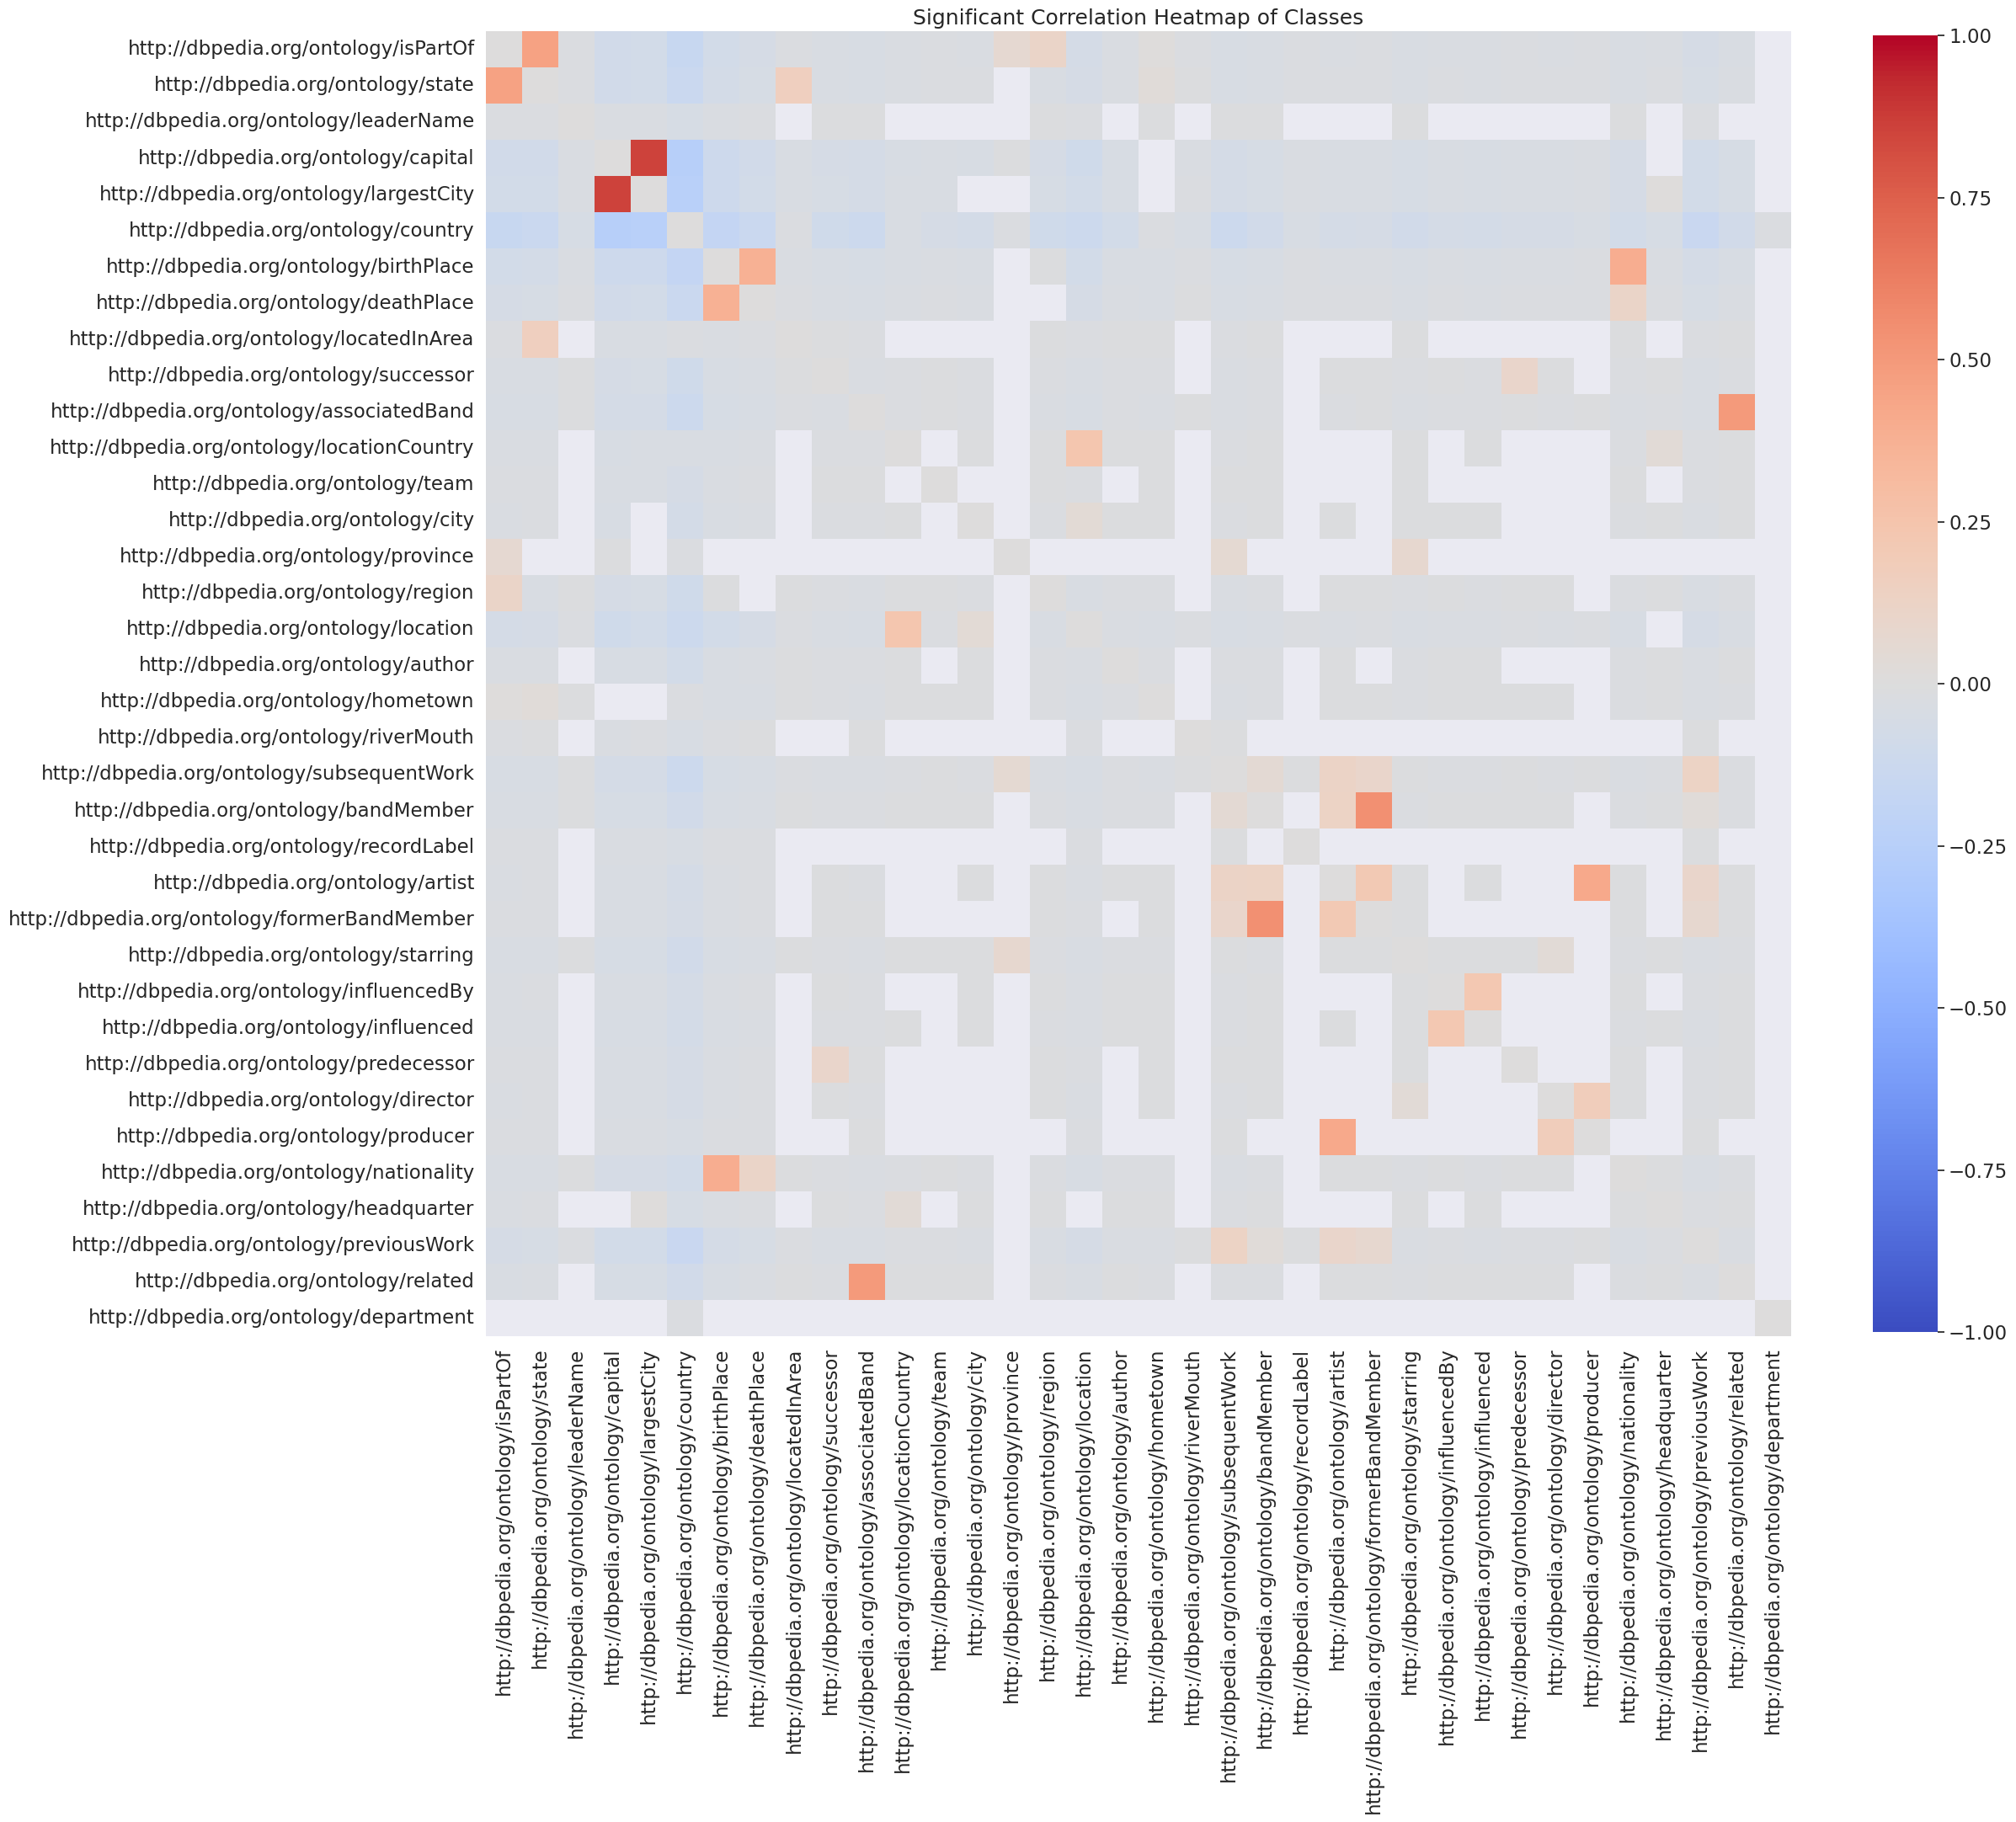

In [14]:
pred_correlation_matrix, significant_mask = significant_correlation_matrix(test_y_pred, link_dict, alpha=0.05)


# Plot the heatmap with significant correlations highlighted
plt.figure(figsize=(25, 25))
sns.heatmap(pred_correlation_matrix, annot=False, cmap='coolwarm', mask=~significant_mask, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Significant Correlation Heatmap of Classes")
plt.grid(False)
plt.show()


In [15]:
#Fill nan with zeros in correlation_matrix_pred
correlation_matrix_pred=pred_correlation_matrix.fillna(0)
correlation_matrix_test=test_correlation_matrix.fillna(0)

distance = np.linalg.norm(correlation_matrix_test - correlation_matrix_pred, 'fro')

distance